# 📺 View channels

In [ ]:
#| default_exp repr_chans

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()

In [ ]:
# |hide
from fastcore.test import test_eq
from nbdev.showdoc import *
from lovely_jax import monkey_patch

In [ ]:
# |hide
# |export
from typing import Any, Optional as O

import jax, jax.numpy as jnp
from matplotlib import axes, figure

from lovely_numpy.utils.utils import cached_property
from lovely_numpy.repr_chans import fig_chans
from lovely_numpy import config as np_config

from lovely_jax.utils.misc import to_numpy
from lovely_jax.utils.config import get_config

In [ ]:
# |hide
jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_platforms', 'cpu')
monkey_patch()

In [ ]:
# |exporti
class ChanProxy():
    def __init__(self, t: jax.Array):
        self.t = t
        self.params = dict(cmap = "twilight",
                    cm_below="blue",
                    cm_above="red",
                    cm_ninf="cyan",
                    cm_pinf="fuchsia",
                    cm_nan="yellow",
                    view_width=966,
                    gutter_px=3,
                    frame_px=1,
                    scale=1,
                    cl=True,
                    ax=None)

    def __call__(self,
                 cmap       :O[str]=None,
                 cm_below   :O[str]=None,
                 cm_above   :O[str]=None,
                 cm_ninf    :O[str]=None,
                 cm_pinf    :O[str]=None,
                 cm_nan     :O[str]=None,
                 view_width :O[int]=None,
                 gutter_px  :O[int]=None,
                 frame_px   :O[int]=None,
                 scale      :O[int]=None,
                 cl         :Any=None,
                 ax         :O[axes.Axes]=None):

        self.params.update( {   k:v for
                                k,v in locals().items()
                                if k != "self" and v is not None } )
        _ = self.fig # Trigger figure generation
        return self

    @cached_property
    def fig(self) -> figure.Figure:
        cfg = get_config()
        with np_config(fig_close=cfg.fig_close, fig_show=cfg.fig_show):
            return fig_chans(to_numpy(self.t), **self.params)

    def _repr_png_(self):
        from IPython.core.pylabtools import print_figure
        return print_figure(self.fig, fmt="png", pad_inches=0,
            metadata={"Software": "Matplotlib, https://matplotlib.org/"})

In [ ]:
# |export
def chans(  x: jax.Array,                # Input, shape=([...], H, W)
            cmap        :str    ="twilight",# Use matplotlib colormap by this name
            cm_below    :str    ="blue",    # Color for values below -1
            cm_above    :str    ="red",     # Color for values above 1
            cm_ninf     :str    ="cyan",    # Color for -inf values
            cm_pinf     :str    ="fuchsia", # Color for +inf values
            cm_nan      :str    ="yellow",  # Color for NaN values
            view_width  :int    =966,       # Try to produce an image at most this wide
            gutter_px   :int    =3,         # Draw write gutters when tiling the images
            frame_px    :int    =1,         # Draw black frame around each image
            scale       :int    =1,
            cl          :Any    =True,
            ax          :O[axes.Axes]=None
        ) -> ChanProxy:

    "Map tensor values to colors. RGB[A] color is added as channel-last"
    args = locals()
    del args["x"]

    return ChanProxy(x)(**args)

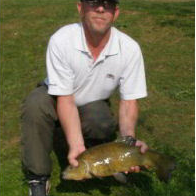

In [ ]:
in_stats = ( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )

image = jnp.load("mysteryman.npy").transpose(1,2,0)
image = (image * jnp.array(in_stats[1]))
image += jnp.array(in_stats[0])

image.rgb

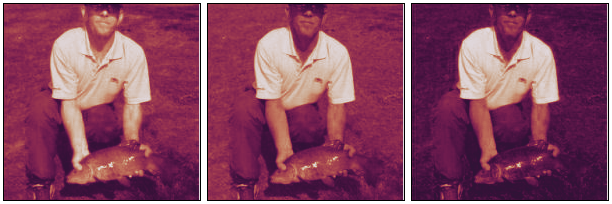

In [ ]:
chans(image)

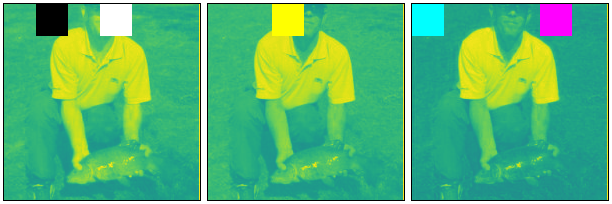

In [ ]:
# In R
image = image.at[0:32,32:64:,0].set(-1.1) # Below min
image = image.at[0:32,96:128,0].set(1.1) # Above max
# In G
image = image.at[0:32,64:96,1].set(float("nan"))
# In B
image = image.at[0:32,0:32,2].set(float("-inf"))
image = image.at[0:32,128:128+32,2].set(float("+inf"))

chans(image, cmap="viridis", cm_below="black", cm_above="white")

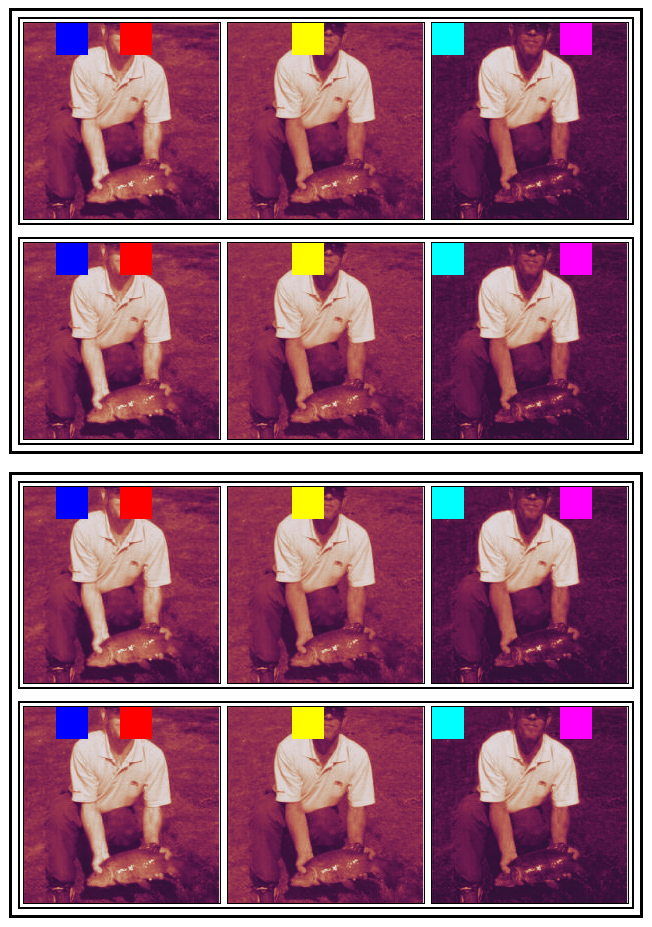

In [ ]:
# 4 images, stacked 2x2
chans(jnp.stack([image]*4).reshape(2,2,196,196,3))

In [ ]:
# |hide

try:
    chans(jnp.array([]).reshape((0,0,0))).fig
except AssertionError as e:
    test_eq(e.args[0], "Expecting non-empty input, got shape=((0, 0, 0, 3))")
else:
    raise AssertionError("Expected AssertionError, but got nothing")
